In [20]:
!pip install mss pydirectinput pytesseract

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [1]:
# MSS для захвата экрана
from mss import mss
# для отправки команд
import pydirectinput
import cv2
import numpy as np
# OCR для извлечения GAME OVER с экрана
import pytesseract
from matplotlib import pyplot as plt
import time
# Enviroment components
from gym import Env
from gym.spaces import Box, Discrete

In [2]:
# Создаем окружающую среду

In [3]:
class WebGame(Env):
    def __init__(self):
        super().__init__()
        self.observation_space = Box(low=0, high=255, shape=(1, 83, 100), dtype=np.uint8)
        self.action_space = Discrete(3)
        # определить параметры захвата экрана
        self.cap = mss()
        self.game_location = {'top':300, 'left': 0, 'width':600, 'height':500}
        self.done_location = {'top':425, 'left': 630, 'width':660, 'height':70}
        
    # для действий в игре
    def step(self, action):
        action_map = {
            0:'space',
            1:'down',
            2:'no_op'
        }
        
        if action != 2:
            pydirectinput.press(action_map[action])
        
        # проверяем завершена ли игра
        done, done_cap = self.get_done()
        # получить следующее наблюдение
        new_observation = self.get_observation()
        # Награда - мы получаем 1 очко за каждый оставшийся в живых кадр.
        reward = 1
        info = {}
        
        return new_observation, reward, done, info
        
    # визуализируем игру
    def render(self):
        cv2.imshow('Game', np.array(self.cap.grab(self.game_location))[:,:,:3])
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()
            
    # для перезапуска игры
    def reset(self):
        time.sleep(1)
        pydirectinput.click(x=150,y=150)
        pydirectinput.press('space')
        return self.get_observation()
        
    def close(self):
        cv2.destroyAllWindows()
        
    # получаем ту часть наблюдения за игрой, которую хотим
    def get_observation(self):
        # получить скриншот игры
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3].astype(np.uint8)
        # grayscale
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        # resize 
        resized = cv2.resize(gray, (100, 83))
        # add channels first
        channel = np.reshape(resized, (1, 83, 100))
        return channel
    
    # для получения текста с помощью OCR
    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location))[:,:,:3]
        # текст
        done_strings = ['GAME', 'GAHE']
        
        # применить OCR
        done = False
        res = pytesseract.image_to_string(done_cap)[:4]
        if res in done_strings:
            done = True
        
        return done, done_cap

In [4]:
env = WebGame()

In [5]:
done, done_cap = env.get_done()

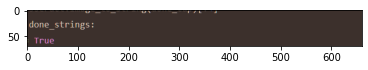

In [6]:
plt.imshow(done_cap)

In [7]:
env.render()

In [8]:
env.close()

In [9]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [10]:
env.reset()

array([[[ 30,  30,  30, ...,  48,  48,  48],
        [ 30,  30,  30, ...,  48,  48,  48],
        [ 30,  30,  30, ...,  48,  48,  48],
        ...,
        [ 30,  30,  30, ..., 140, 167, 100],
        [ 30,  30,  30, ...,  48,  48,  48],
        [ 30,  30,  30, ...,  48,  48,  48]]], dtype=uint8)

In [11]:
# Тестируем среду

In [12]:
env = WebGame()

In [13]:
obs = env.get_observation()

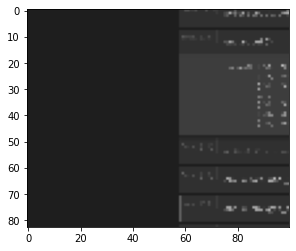

In [14]:
plt.imshow(cv2.cvtColor(obs[0], cv2.COLOR_BGR2RGB))

In [15]:
done, done_cap = env.get_done()
print(done)

False


In [16]:
pytesseract.image_to_string(done_cap)[:4]

''

In [17]:
# сыграем 10 игр
for episode in range(10):
    obs = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        obs, reward, done, info = env.step(env.action_space.sample())
        total_reward += reward
    print(f'Total reward for episode {episode} is {total_reward}')

Total reward for episode 0 is 18
Total reward for episode 1 is 14
Total reward for episode 2 is 14
Total reward for episode 3 is 15
Total reward for episode 4 is 14
Total reward for episode 5 is 15
Total reward for episode 6 is 14
Total reward for episode 7 is 17
Total reward for episode 8 is 20
Total reward for episode 9 is 15


In [18]:
# Обучение модели

In [19]:
# создаем Callback

In [17]:
import os 
from stable_baselines3.common.callbacks import BaseCallback
  from stable_baselines3.common import env_checker

In [18]:
# проверка среды
env_checker.check_env(env)

In [19]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [20]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logss/'

In [21]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

In [22]:
# Создаем и обучаем DQN

In [23]:
from stable_baselines3 import DQN

In [36]:
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, 
            verbose=1, buffer_size=10000, learning_starts=1000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
# начинаем обучение
model.learn(total_timesteps=100000, callback=callback)   

Logging to ./logss/DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.5      |
|    ep_rew_mean      | 9.5      |
|    exploration_rate | 0.996    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1        |
|    time_elapsed     | 27       |
|    total_timesteps  | 38       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13       |
|    ep_rew_mean      | 13       |
|    exploration_rate | 0.99     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1        |
|    time_elapsed     | 56       |
|    total_timesteps  | 104      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.8     |
|    ep_rew_mean      | 13.8     |
|    exploration_rate | 0.984    |
| time/               |       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.9     |
|    ep_rew_mean      | 15.9     |
|    exploration_rate | 0.873    |
| time/               |          |
|    episodes         | 84       |
|    fps              | 2        |
|    time_elapsed     | 603      |
|    total_timesteps  | 1336     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000116 |
|    n_updates        | 83       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16       |
|    ep_rew_mean      | 16       |
|    exploration_rate | 0.866    |
| time/               |          |
|    episodes         | 88       |
|    fps              | 2        |
|    time_elapsed     | 630      |
|    total_timesteps  | 1406     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.09e-05 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.8     |
|    ep_rew_mean      | 16.8     |
|    exploration_rate | 0.77     |
| time/               |          |
|    episodes         | 148      |
|    fps              | 2        |
|    time_elapsed     | 1050     |
|    total_timesteps  | 2420     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.1e-05  |
|    n_updates        | 354      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.8     |
|    ep_rew_mean      | 16.8     |
|    exploration_rate | 0.763    |
| time/               |          |
|    episodes         | 152      |
|    fps              | 2        |
|    time_elapsed     | 1077     |
|    total_timesteps  | 2493     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.94e-05 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 17.4     |
|    ep_rew_mean      | 17.4     |
|    exploration_rate | 0.664    |
| time/               |          |
|    episodes         | 212      |
|    fps              | 2        |
|    time_elapsed     | 1499     |
|    total_timesteps  | 3533     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.99e-05 |
|    n_updates        | 633      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 17.4     |
|    ep_rew_mean      | 17.4     |
|    exploration_rate | 0.658    |
| time/               |          |
|    episodes         | 216      |
|    fps              | 2        |
|    time_elapsed     | 1527     |
|    total_timesteps  | 3596     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.5e-05  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 17.1     |
|    ep_rew_mean      | 17.1     |
|    exploration_rate | 0.561    |
| time/               |          |
|    episodes         | 276      |
|    fps              | 2        |
|    time_elapsed     | 1946     |
|    total_timesteps  | 4617     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.45e-05 |
|    n_updates        | 904      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 17.2     |
|    ep_rew_mean      | 17.2     |
|    exploration_rate | 0.554    |
| time/               |          |
|    episodes         | 280      |
|    fps              | 2        |
|    time_elapsed     | 1976     |
|    total_timesteps  | 4693     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.75e-06 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 17.6     |
|    ep_rew_mean      | 17.6     |
|    exploration_rate | 0.452    |
| time/               |          |
|    episodes         | 340      |
|    fps              | 2        |
|    time_elapsed     | 2402     |
|    total_timesteps  | 5764     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.43e-06 |
|    n_updates        | 1190     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 17.6     |
|    ep_rew_mean      | 17.6     |
|    exploration_rate | 0.446    |
| time/               |          |
|    episodes         | 344      |
|    fps              | 2        |
|    time_elapsed     | 2430     |
|    total_timesteps  | 5833     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.03e-06 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 17.9     |
|    ep_rew_mean      | 17.9     |
|    exploration_rate | 0.345    |
| time/               |          |
|    episodes         | 404      |
|    fps              | 2        |
|    time_elapsed     | 2844     |
|    total_timesteps  | 6893     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.45e-06 |
|    n_updates        | 1473     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 17.8     |
|    ep_rew_mean      | 17.8     |
|    exploration_rate | 0.339    |
| time/               |          |
|    episodes         | 408      |
|    fps              | 2        |
|    time_elapsed     | 2872     |
|    total_timesteps  | 6958     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.5e-06  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 17.5     |
|    ep_rew_mean      | 17.5     |
|    exploration_rate | 0.239    |
| time/               |          |
|    episodes         | 468      |
|    fps              | 2        |
|    time_elapsed     | 3297     |
|    total_timesteps  | 8006     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.96e-05 |
|    n_updates        | 1751     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 17.7     |
|    ep_rew_mean      | 17.7     |
|    exploration_rate | 0.231    |
| time/               |          |
|    episodes         | 472      |
|    fps              | 2        |
|    time_elapsed     | 3327     |
|    total_timesteps  | 8093     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.52e-05 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 17.3     |
|    ep_rew_mean      | 17.3     |
|    exploration_rate | 0.136    |
| time/               |          |
|    episodes         | 532      |
|    fps              | 2        |
|    time_elapsed     | 3742     |
|    total_timesteps  | 9091     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.23e-06 |
|    n_updates        | 2022     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 17.3     |
|    ep_rew_mean      | 17.3     |
|    exploration_rate | 0.13     |
| time/               |          |
|    episodes         | 536      |
|    fps              | 2        |
|    time_elapsed     | 3770     |
|    total_timesteps  | 9160     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.36e-07 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 17.9     |
|    ep_rew_mean      | 17.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 596      |
|    fps              | 2        |
|    time_elapsed     | 4193     |
|    total_timesteps  | 10269    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00334  |
|    n_updates        | 2317     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 17.9     |
|    ep_rew_mean      | 17.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 600      |
|    fps              | 2        |
|    time_elapsed     | 4223     |
|    total_timesteps  | 10338    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0226   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 18.6     |
|    ep_rew_mean      | 18.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 660      |
|    fps              | 2        |
|    time_elapsed     | 4644     |
|    total_timesteps  | 11470    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00156  |
|    n_updates        | 2617     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 18.5     |
|    ep_rew_mean      | 18.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 664      |
|    fps              | 2        |
|    time_elapsed     | 4671     |
|    total_timesteps  | 11529    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00475  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 18.4     |
|    ep_rew_mean      | 18.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 724      |
|    fps              | 2        |
|    time_elapsed     | 5074     |
|    total_timesteps  | 12623    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00595  |
|    n_updates        | 2905     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 18.4     |
|    ep_rew_mean      | 18.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 728      |
|    fps              | 2        |
|    time_elapsed     | 5100     |
|    total_timesteps  | 12708    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0137   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 18       |
|    ep_rew_mean      | 18       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 788      |
|    fps              | 2        |
|    time_elapsed     | 5503     |
|    total_timesteps  | 13773    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0106   |
|    n_updates        | 3193     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 18       |
|    ep_rew_mean      | 18       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 792      |
|    fps              | 2        |
|    time_elapsed     | 5530     |
|    total_timesteps  | 13853    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00145  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 17.6     |
|    ep_rew_mean      | 17.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 852      |
|    fps              | 2        |
|    time_elapsed     | 5935     |
|    total_timesteps  | 14897    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00176  |
|    n_updates        | 3474     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 17.8     |
|    ep_rew_mean      | 17.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 856      |
|    fps              | 2        |
|    time_elapsed     | 5964     |
|    total_timesteps  | 14977    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00265  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 17.6     |
|    ep_rew_mean      | 17.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 916      |
|    fps              | 2        |
|    time_elapsed     | 6376     |
|    total_timesteps  | 16027    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0014   |
|    n_updates        | 3756     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 17.9     |
|    ep_rew_mean      | 17.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 920      |
|    fps              | 2        |
|    time_elapsed     | 6403     |
|    total_timesteps  | 16118    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00147  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 17.7     |
|    ep_rew_mean      | 17.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 980      |
|    fps              | 2        |
|    time_elapsed     | 6824     |
|    total_timesteps  | 17179    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00122  |
|    n_updates        | 4044     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 17.7     |
|    ep_rew_mean      | 17.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 984      |
|    fps              | 2        |
|    time_elapsed     | 6852     |
|    total_timesteps  | 17249    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000434 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 17.7     |
|    ep_rew_mean      | 17.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1044     |
|    fps              | 2        |
|    time_elapsed     | 7266     |
|    total_timesteps  | 18310    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00256  |
|    n_updates        | 4327     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 17.7     |
|    ep_rew_mean      | 17.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1048     |
|    fps              | 2        |
|    time_elapsed     | 7293     |
|    total_timesteps  | 18378    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000729 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.8     |
|    ep_rew_mean      | 16.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1108     |
|    fps              | 2        |
|    time_elapsed     | 7715     |
|    total_timesteps  | 19409    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000415 |
|    n_updates        | 4602     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.8     |
|    ep_rew_mean      | 16.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1112     |
|    fps              | 2        |
|    time_elapsed     | 7743     |
|    total_timesteps  | 19469    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00434  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 18.5     |
|    ep_rew_mean      | 18.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1172     |
|    fps              | 2        |
|    time_elapsed     | 8220     |
|    total_timesteps  | 20653    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00973  |
|    n_updates        | 4913     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 18.6     |
|    ep_rew_mean      | 18.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1176     |
|    fps              | 2        |
|    time_elapsed     | 8255     |
|    total_timesteps  | 20746    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0145   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 23.9     |
|    ep_rew_mean      | 23.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1236     |
|    fps              | 2        |
|    time_elapsed     | 8831     |
|    total_timesteps  | 22259    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0153   |
|    n_updates        | 5314     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24.6     |
|    ep_rew_mean      | 24.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1240     |
|    fps              | 2        |
|    time_elapsed     | 8875     |
|    total_timesteps  | 22380    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00789  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 26.9     |
|    ep_rew_mean      | 26.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1300     |
|    fps              | 2        |
|    time_elapsed     | 9454     |
|    total_timesteps  | 23998    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0226   |
|    n_updates        | 5749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 27.1     |
|    ep_rew_mean      | 27.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1304     |
|    fps              | 2        |
|    time_elapsed     | 9504     |
|    total_timesteps  | 24135    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00392  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 27.6     |
|    ep_rew_mean      | 27.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1364     |
|    fps              | 2        |
|    time_elapsed     | 10107    |
|    total_timesteps  | 25792    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0467   |
|    n_updates        | 6197     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 27.8     |
|    ep_rew_mean      | 27.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1368     |
|    fps              | 2        |
|    time_elapsed     | 10149    |
|    total_timesteps  | 25908    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00777  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.8     |
|    ep_rew_mean      | 28.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1428     |
|    fps              | 2        |
|    time_elapsed     | 10786    |
|    total_timesteps  | 27719    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00247  |
|    n_updates        | 6679     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.1     |
|    ep_rew_mean      | 29.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1432     |
|    fps              | 2        |
|    time_elapsed     | 10829    |
|    total_timesteps  | 27868    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0117   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.3     |
|    ep_rew_mean      | 29.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1492     |
|    fps              | 2        |
|    time_elapsed     | 11445    |
|    total_timesteps  | 29561    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00835  |
|    n_updates        | 7140     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.5     |
|    ep_rew_mean      | 29.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1496     |
|    fps              | 2        |
|    time_elapsed     | 11487    |
|    total_timesteps  | 29681    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0012   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.3     |
|    ep_rew_mean      | 30.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1556     |
|    fps              | 2        |
|    time_elapsed     | 12115    |
|    total_timesteps  | 31506    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0506   |
|    n_updates        | 7626     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.7     |
|    ep_rew_mean      | 30.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1560     |
|    fps              | 2        |
|    time_elapsed     | 12161    |
|    total_timesteps  | 31654    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0749   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.2     |
|    ep_rew_mean      | 30.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1620     |
|    fps              | 2        |
|    time_elapsed     | 12811    |
|    total_timesteps  | 33464    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0841   |
|    n_updates        | 8115     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.6     |
|    ep_rew_mean      | 30.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1624     |
|    fps              | 2        |
|    time_elapsed     | 12852    |
|    total_timesteps  | 33612    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0864   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | 33.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1684     |
|    fps              | 2        |
|    time_elapsed     | 13542    |
|    total_timesteps  | 35781    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0612   |
|    n_updates        | 8695     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | 34.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1688     |
|    fps              | 2        |
|    time_elapsed     | 13591    |
|    total_timesteps  | 35934    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0331   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | 36.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1748     |
|    fps              | 2        |
|    time_elapsed     | 14280    |
|    total_timesteps  | 38010    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0331   |
|    n_updates        | 9252     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | 34.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1752     |
|    fps              | 2        |
|    time_elapsed     | 14315    |
|    total_timesteps  | 38104    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00263  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | 33.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1812     |
|    fps              | 2        |
|    time_elapsed     | 14969    |
|    total_timesteps  | 40126    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00538  |
|    n_updates        | 9781     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | 33.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1816     |
|    fps              | 2        |
|    time_elapsed     | 15027    |
|    total_timesteps  | 40320    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00282  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | 37.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1876     |
|    fps              | 2        |
|    time_elapsed     | 15693    |
|    total_timesteps  | 42469    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00263  |
|    n_updates        | 10367    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.6     |
|    ep_rew_mean      | 37.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1880     |
|    fps              | 2        |
|    time_elapsed     | 15741    |
|    total_timesteps  | 42637    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0087   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 40       |
|    ep_rew_mean      | 40       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1940     |
|    fps              | 2        |
|    time_elapsed     | 16477    |
|    total_timesteps  | 45107    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00934  |
|    n_updates        | 11026    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 40.2     |
|    ep_rew_mean      | 40.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1944     |
|    fps              | 2        |
|    time_elapsed     | 16524    |
|    total_timesteps  | 45294    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00434  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 41.3     |
|    ep_rew_mean      | 41.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2004     |
|    fps              | 2        |
|    time_elapsed     | 17228    |
|    total_timesteps  | 47699    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.115    |
|    n_updates        | 11674    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 41.9     |
|    ep_rew_mean      | 41.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2008     |
|    fps              | 2        |
|    time_elapsed     | 17275    |
|    total_timesteps  | 47906    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0633   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 40.8     |
|    ep_rew_mean      | 40.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2068     |
|    fps              | 2        |
|    time_elapsed     | 17987    |
|    total_timesteps  | 50229    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0213   |
|    n_updates        | 12307    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 41.5     |
|    ep_rew_mean      | 41.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2072     |
|    fps              | 2        |
|    time_elapsed     | 18046    |
|    total_timesteps  | 50426    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.142    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42       |
|    ep_rew_mean      | 42       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2132     |
|    fps              | 2        |
|    time_elapsed     | 18791    |
|    total_timesteps  | 53001    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00768  |
|    n_updates        | 13000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 41.8     |
|    ep_rew_mean      | 41.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2136     |
|    fps              | 2        |
|    time_elapsed     | 18830    |
|    total_timesteps  | 53141    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0547   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.7     |
|    ep_rew_mean      | 45.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2196     |
|    fps              | 2        |
|    time_elapsed     | 19594    |
|    total_timesteps  | 55936    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0281   |
|    n_updates        | 13733    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 46.2     |
|    ep_rew_mean      | 46.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2200     |
|    fps              | 2        |
|    time_elapsed     | 19657    |
|    total_timesteps  | 56178    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00778  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.5     |
|    ep_rew_mean      | 45.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2260     |
|    fps              | 2        |
|    time_elapsed     | 20375    |
|    total_timesteps  | 58744    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0143   |
|    n_updates        | 14435    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.5     |
|    ep_rew_mean      | 44.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2264     |
|    fps              | 2        |
|    time_elapsed     | 20423    |
|    total_timesteps  | 58882    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0824   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.7     |
|    ep_rew_mean      | 42.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2324     |
|    fps              | 2        |
|    time_elapsed     | 21125    |
|    total_timesteps  | 61479    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0673   |
|    n_updates        | 15119    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.5     |
|    ep_rew_mean      | 42.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2328     |
|    fps              | 2        |
|    time_elapsed     | 21169    |
|    total_timesteps  | 61650    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.221    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.8     |
|    ep_rew_mean      | 42.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2388     |
|    fps              | 2        |
|    time_elapsed     | 21904    |
|    total_timesteps  | 64239    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0212   |
|    n_updates        | 15809    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.3     |
|    ep_rew_mean      | 42.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2392     |
|    fps              | 2        |
|    time_elapsed     | 21946    |
|    total_timesteps  | 64372    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.124    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.6     |
|    ep_rew_mean      | 44.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2452     |
|    fps              | 2        |
|    time_elapsed     | 22748    |
|    total_timesteps  | 67149    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.156    |
|    n_updates        | 16537    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.2     |
|    ep_rew_mean      | 44.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2456     |
|    fps              | 2        |
|    time_elapsed     | 22801    |
|    total_timesteps  | 67294    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0172   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.8     |
|    ep_rew_mean      | 43.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2516     |
|    fps              | 2        |
|    time_elapsed     | 23513    |
|    total_timesteps  | 69771    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0226   |
|    n_updates        | 17192    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.4     |
|    ep_rew_mean      | 43.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2520     |
|    fps              | 2        |
|    time_elapsed     | 23562    |
|    total_timesteps  | 69952    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0169   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.3     |
|    ep_rew_mean      | 37.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2580     |
|    fps              | 2        |
|    time_elapsed     | 24230    |
|    total_timesteps  | 72005    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.264    |
|    n_updates        | 17751    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | 36.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2584     |
|    fps              | 2        |
|    time_elapsed     | 24266    |
|    total_timesteps  | 72093    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0029   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.1     |
|    ep_rew_mean      | 33.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2644     |
|    fps              | 2        |
|    time_elapsed     | 24950    |
|    total_timesteps  | 74154    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0364   |
|    n_updates        | 18288    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.4     |
|    ep_rew_mean      | 33.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2648     |
|    fps              | 2        |
|    time_elapsed     | 24999    |
|    total_timesteps  | 74296    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.253    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.3     |
|    ep_rew_mean      | 34.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2708     |
|    fps              | 2        |
|    time_elapsed     | 25672    |
|    total_timesteps  | 76383    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00937  |
|    n_updates        | 18845    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.4     |
|    ep_rew_mean      | 34.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2712     |
|    fps              | 2        |
|    time_elapsed     | 25711    |
|    total_timesteps  | 76502    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.166    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.2     |
|    ep_rew_mean      | 33.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2772     |
|    fps              | 2        |
|    time_elapsed     | 26359    |
|    total_timesteps  | 78501    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.176    |
|    n_updates        | 19375    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | 33       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2776     |
|    fps              | 2        |
|    time_elapsed     | 26400    |
|    total_timesteps  | 78629    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.16     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | 35       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2836     |
|    fps              | 2        |
|    time_elapsed     | 27071    |
|    total_timesteps  | 80840    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.218    |
|    n_updates        | 19959    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | 35.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2840     |
|    fps              | 2        |
|    time_elapsed     | 27115    |
|    total_timesteps  | 81001    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0194   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 41.4     |
|    ep_rew_mean      | 41.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2900     |
|    fps              | 3        |
|    time_elapsed     | 27815    |
|    total_timesteps  | 83462    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0164   |
|    n_updates        | 20615    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 41.2     |
|    ep_rew_mean      | 41.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2904     |
|    fps              | 3        |
|    time_elapsed     | 27854    |
|    total_timesteps  | 83591    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.358    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.4     |
|    ep_rew_mean      | 44.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2964     |
|    fps              | 3        |
|    time_elapsed     | 28635    |
|    total_timesteps  | 86349    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.197    |
|    n_updates        | 21337    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45       |
|    ep_rew_mean      | 45       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2968     |
|    fps              | 3        |
|    time_elapsed     | 28686    |
|    total_timesteps  | 86549    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.035    |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43       |
|    ep_rew_mean      | 43       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3028     |
|    fps              | 3        |
|    time_elapsed     | 29369    |
|    total_timesteps  | 88962    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00862  |
|    n_updates        | 21990    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.3     |
|    ep_rew_mean      | 42.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3032     |
|    fps              | 3        |
|    time_elapsed     | 29421    |
|    total_timesteps  | 89145    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0258   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.2     |
|    ep_rew_mean      | 39.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3092     |
|    fps              | 3        |
|    time_elapsed     | 30118    |
|    total_timesteps  | 91472    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.094    |
|    n_updates        | 22617    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.4     |
|    ep_rew_mean      | 39.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3096     |
|    fps              | 3        |
|    time_elapsed     | 30169    |
|    total_timesteps  | 91636    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0199   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | 36.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3156     |
|    fps              | 3        |
|    time_elapsed     | 30830    |
|    total_timesteps  | 93780    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.049    |
|    n_updates        | 23194    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | 36.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3160     |
|    fps              | 3        |
|    time_elapsed     | 30873    |
|    total_timesteps  | 93938    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0391   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | 36.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3220     |
|    fps              | 3        |
|    time_elapsed     | 31563    |
|    total_timesteps  | 96158    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0222   |
|    n_updates        | 23789    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | 36.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3224     |
|    fps              | 3        |
|    time_elapsed     | 31620    |
|    total_timesteps  | 96334    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00928  |
|    n_updates      

In [ ]:
model.load('train/best_model_97000') 

In [27]:
# Проверка модели

In [ ]:
for episode in range(5): 
    obs = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(int(action))
        time.sleep(0.01)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))
    time.sleep(2)